# Reading data from CSV file and filtering Apple stock price 

In [1]:
import pandas as pd
import numpy as np
allData = pd.read_csv('Data//all_stocks_5yr.csv', index_col=['date'], parse_dates=['date'])
df = allData[allData['Name'] == 'AAPL']
del df['open']
del df['high']
del df['low']
del df['volume']
del df['Name']

# Weighted Moving Average (WMA)

In [2]:
def weighted_moving_average(series, weights):
    n = len(weights)
    weighted_moving_aves = []
    for i in range(len(series)):
        if i >= n - 1:
            data = series[i - n + 1:i + 1]            
            weighted_moving_aves.append(np.dot(data, weights))
        else:
            weighted_moving_aves.append(None)
        
    return weighted_moving_aves

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
weights = [.01,.01,.01,.01,.01,.02,.02,.02,.02,.02,.03,.03,.03,.03,.03,.05,.05,.05,.05,.05,.07,.08,.09,.10,.11]
df['wma'] = weighted_moving_average(df['close'], weights)

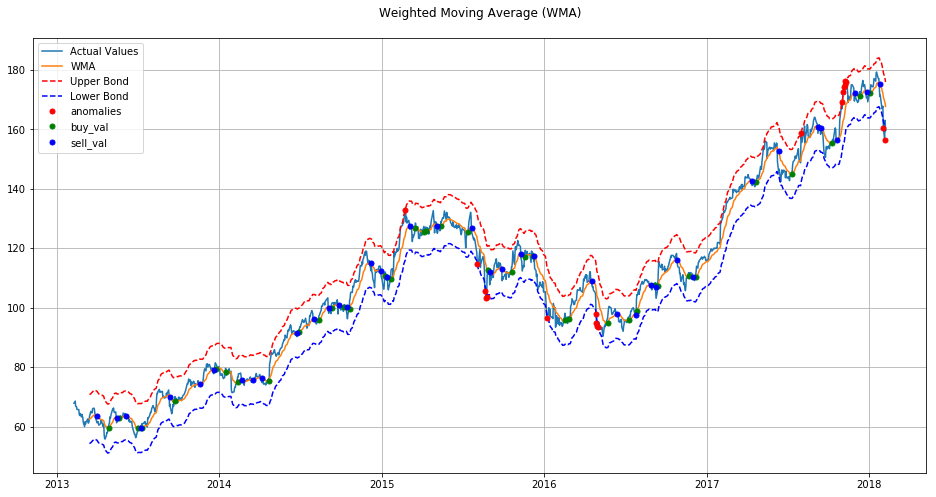

In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
#from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

window = len(weights)
scale = 1.96

plt.figure(figsize=(16,8))
plt.title("Weighted Moving Average (WMA)\n")

plt.plot(df['close'], label="Actual Values")
plt.plot(df['wma'], label="WMA")


rolling_mean = df['wma']
series = df['close']
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
df['lower_bond'] = rolling_mean - (mae + scale * deviation)
df['upper_bond'] = rolling_mean + (mae + scale * deviation)
plt.plot(df['upper_bond'], "r--", label="Upper Bond")
plt.plot(df['lower_bond'], "b--",  label="Lower Bond")
        
df['anomalies'] = float('NaN')
df['anomalies'][series < df['lower_bond']] = series[series < df['lower_bond']]
df['anomalies'][series > df['upper_bond']] = series[series > df['upper_bond']]
plt.plot(df['anomalies'], "ro", markersize = 5)


df['wma_prev1'] = df['wma'].shift(1)
df['wma_prev2'] = df['wma'].shift(2)
df['wma_prev3'] = df['wma'].shift(3)
df['wma_prev4'] = df['wma'].shift(4)
df['sell'] = (df['wma_prev1'] > df['close']) & (df['wma_prev2'] > df['wma_prev1']) & (df['wma_prev3'] < df['wma_prev2']) & (df['wma_prev3'] > df['wma_prev4'])
df['buy'] = (df['wma_prev1'] < df['close']) & (df['wma_prev2'] < df['wma_prev1']) & (df['wma_prev3'] > df['wma_prev2']) & (df['wma_prev3'] < df['wma_prev4'])
df['buy_val'] = df[df['buy'] == True]['wma']
df['sell_val'] = df[df['sell'] == True]['wma']

plt.plot(df['buy_val'], "go", markersize = 5)
plt.plot(df['sell_val'], "bo", markersize = 5)

plt.legend(loc="upper left")    
plt.grid(True)
plt.show()

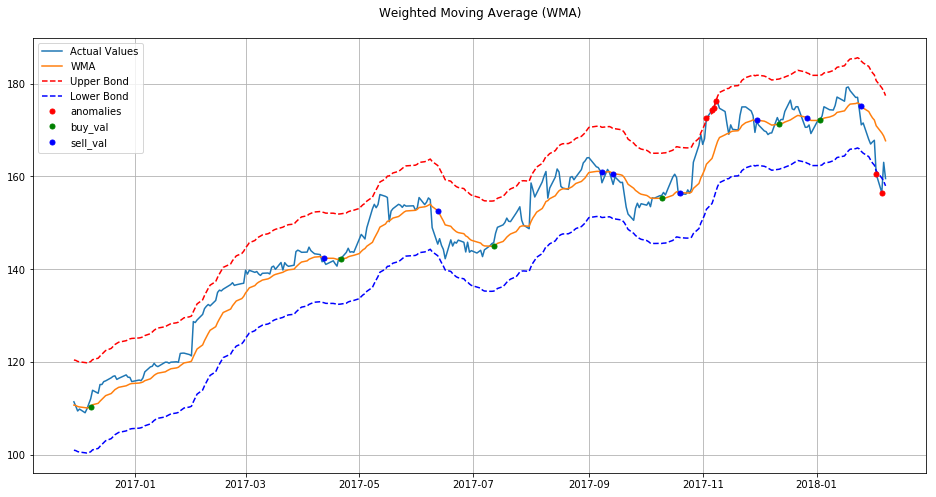

In [6]:
df = df[-300:]

window = len(weights)
scale = 1.96

plt.figure(figsize=(16,8))
plt.title("Weighted Moving Average (WMA)\n")

plt.plot(df['close'], label="Actual Values")
plt.plot(df['wma'], label="WMA")


rolling_mean = df['wma']
series = df['close']
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
df['lower_bond'] = rolling_mean - (mae + scale * deviation)
df['upper_bond'] = rolling_mean + (mae + scale * deviation)
plt.plot(df['upper_bond'], "r--", label="Upper Bond")
plt.plot(df['lower_bond'], "b--",  label="Lower Bond")
        
df['anomalies'] = float('NaN')
df['anomalies'][series < df['lower_bond']] = series[series < df['lower_bond']]
df['anomalies'][series > df['upper_bond']] = series[series > df['upper_bond']]
plt.plot(df['anomalies'], "ro", markersize = 5)


df['wma_prev1'] = df['wma'].shift(1)
df['wma_prev2'] = df['wma'].shift(2)
df['wma_prev3'] = df['wma'].shift(3)
df['wma_prev4'] = df['wma'].shift(4)
df['sell'] = (df['wma_prev1'] > df['close']) & (df['wma_prev2'] > df['wma_prev1']) & (df['wma_prev3'] < df['wma_prev2']) & (df['wma_prev3'] > df['wma_prev4'])
df['buy'] = (df['wma_prev1'] < df['close']) & (df['wma_prev2'] < df['wma_prev1']) & (df['wma_prev3'] > df['wma_prev2']) & (df['wma_prev3'] < df['wma_prev4'])
df['buy_val'] = df[df['buy'] == True]['wma']
df['sell_val'] = df[df['sell'] == True]['wma']

plt.plot(df['buy_val'], "go", markersize = 5)
plt.plot(df['sell_val'], "bo", markersize = 5)

plt.legend(loc="upper left")    
plt.grid(True)
plt.show()

In [7]:
amount = 0
share = 10000.0 / df.iloc[0]['close']
print('Buy: ', df.index[0], amount, share, df.iloc[0]['close'])

for index, row in df.iterrows():
    if (amount > 0) and (row['buy'] == True):
        print('Buy: ', index,  amount, share, row['close'])
        share = amount / row['close']
        amount = 0
    elif (amount == 0) and (row['sell'] == True):
        print('Sel: ', index, amount, share, row['close'])
        amount = share * row['close']
        share = 0 

print(amount, share)

Buy:  2016-11-29 00:00:00 0 89.7182845864 111.46
Sel:  2017-04-12 00:00:00 0 89.7182845864 141.8
Buy:  2017-04-21 00:00:00 12722.0527544 0 142.27
Sel:  2017-06-12 00:00:00 0 89.4218932618 145.42
Buy:  2017-07-12 00:00:00 13003.7317181 0 145.74
Sel:  2017-09-08 00:00:00 0 89.2255504194 158.63
Buy:  2017-10-10 00:00:00 14153.849063 0 155.9
Sel:  2017-10-20 00:00:00 0 90.7879991214 156.25
Buy:  2017-12-12 00:00:00 14185.6248627 0 171.7
Sel:  2017-12-27 00:00:00 0 82.6186654789 170.6
Buy:  2018-01-03 00:00:00 14094.7443307 0 172.23
Sel:  2018-01-25 00:00:00 0 81.836755099 171.11
14003.087165 0
